# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [2]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
# basic cleaning function:
# ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

# def clean(text):
#     '''Simplified text cleaning function'''
#     stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
#     text = text.lower()
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#     words = re.sub(r"[^a-z0-9\s]", '', text)
#     return [word for word in words if word not in stopwords]

In [5]:
# acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape

(5572, 2)

### If we look at this in the context of a classification problem,
we may ask:
 - What leads to a spam text?
 - What leads to a ham text?
 

In [7]:
df.iloc[1].text

'Ok lar... Joking wif u oni...'

In [8]:
# recall how the string method join operates -- glues together 
# all instances inside of a iterable using whatever is specified
# ahead of the method call:
# english: glue these words together with a empty space
' '.join(['this ', 'is ', 'a ', 'list of strings'])

'this  is  a  list of strings'

In [9]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that
ham_words = clean(' '.join(df[df.label == 'ham']['text']))
spam_words = clean(' '.join(df[df.label == 'spam']['text']))
all_words = clean(' '.join(df['text']))

In [14]:
# ham_words

In [10]:
len(all_words), len(spam_words), len(ham_words)

(50305, 12163, 38142)

In [11]:
# df[df.label == 'ham']['text']

In [16]:
# ham_words

In [17]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [18]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [19]:
ham_freq.head(5)

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

## Exploration

Represent text as word frequencies.

In [20]:
# concat all frequencies together into a dataframe

In [21]:
# lets join these words together into a dataframe based 
# on my frequency series:
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1
         ).fillna(0).astype(int)
word_counts.columns = ['ham','spam','all']
word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [22]:
word_counts.sample(5).head()

,ham,spam,all
_,4,0,4
cuddling,2,0,2
mark,8,0,8
camera,3,33,36
pool,2,0,2


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [24]:
# sort by 'all'

word_counts.sort_values('all', ascending=False)

,ham,spam,all
call,241,359,600
im,449,13,462
get,314,83,397
ur,240,144,384
go,273,31,304
...,...,...,...
doesdiscountshitinnit,1,0,1
4years,1,0,1
dont4get2text,1,0,1
iknow,1,0,1


In [25]:
# sort by 'ham' and 'spam' columns
word_counts.sort_values(['ham','spam', 'all'], ascending=False)

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279
...,...,...,...
sextextukcom,0,1,1
global,0,1,1
zebra,0,1,1
2ez,0,1,1


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

<AxesSubplot:>

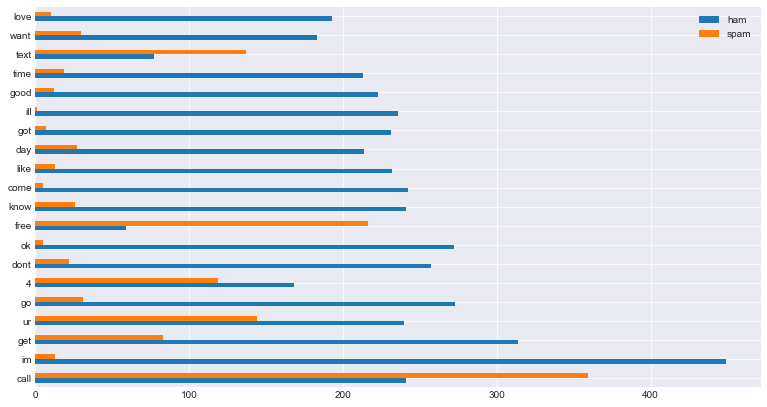

In [29]:
# plt.rc('font', size=18)
word_counts.sort_values(
    'all', ascending=False
)[['ham','spam']].head(20).plot.barh()

In [32]:
word_counts.sort_values('all', ascending=False)\
 .head(20)\
 .apply(lambda row: row/row['all'], axis = 1)

,ham,spam,all
call,0.401667,0.598333,1.0
im,0.971861,0.028139,1.0
get,0.790932,0.209068,1.0
ur,0.625000,0.375000,1.0
go,0.898026,0.101974,1.0
4,0.585366,0.414634,1.0
dont,0.921147,0.078853,1.0
ok,0.981949,0.018051,1.0
free,0.214545,0.785455,1.0
know,0.902622,0.097378,1.0


Text(0.5, 1.0, '% of spam vs ham for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

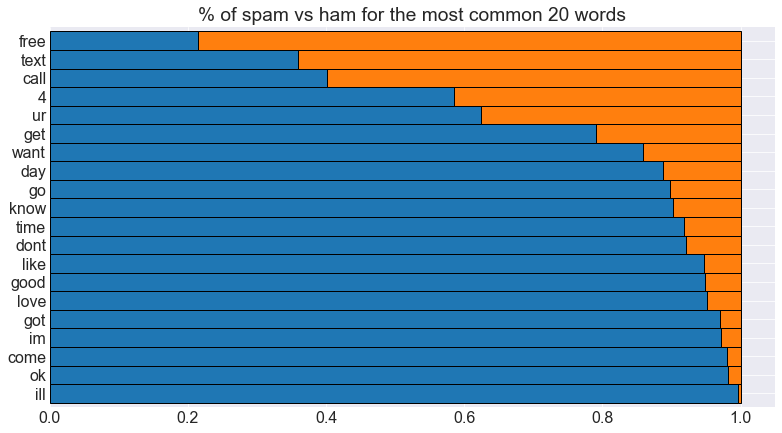

In [34]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'spam')
 .plot.barh(stacked = True, width = 1, ec = 'k', legend=False)
)
plt.title('% of spam vs ham for the most common 20 words')

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [35]:
sentence = 'Today is tuesday, and the weather is nice.'

In [39]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'tuesday,'),
 ('tuesday,', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'nice.')]

**Be Careful!** Make sure you are making bigrams out of *words*.

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

In [42]:
list(nltk.ngrams(sentence.split(), 3))

[('Today', 'is', 'tuesday,'),
 ('is', 'tuesday,', 'and'),
 ('tuesday,', 'and', 'the'),
 ('and', 'the', 'weather'),
 ('the', 'weather', 'is'),
 ('weather', 'is', 'nice.')]

<AxesSubplot:>

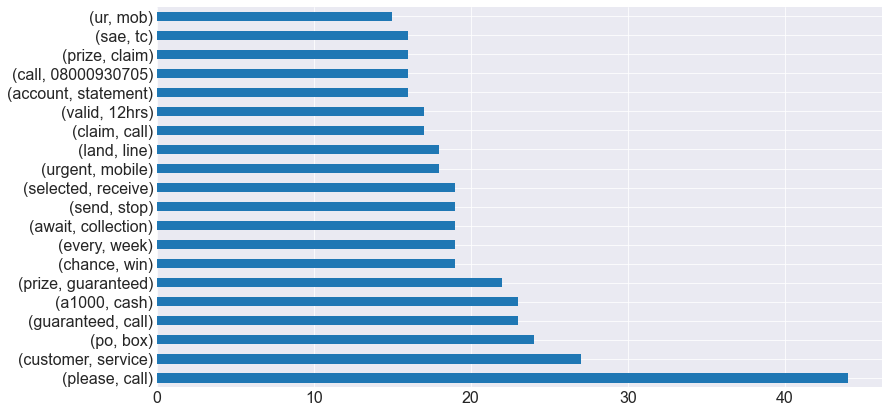

In [48]:
pd.Series(nltk.bigrams(spam_words)
         ).value_counts().head(20).plot.barh()

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [ ]:
# add two new columns 'message_length' and 'word_count'

## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [ ]:
import nltk.sentiment

sia = nltk.sentiment.SentimentIntensityAnalyzer()
sia.polarity_scores('He is really good')

In [ ]:
sia.polarity_scores('He is really good!!!')

In [ ]:
sia.polarity_scores('He is REALLY good')

In [ ]:
sia.polarity_scores('He is very good!!!')

In [ ]:
sia.polarity_scores('The food is good but service is slow')

In [ ]:
sia.polarity_scores('He is good :-)')

In [ ]:
sia.polarity_scores('she is vegan :/')

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [ ]:
df['sentiment'] = df.text.apply(lambda doc: sia.polarity_scores(doc)['compound'])
df

In [ ]:
# is the mean and median values of sentiment score different for ham vs spam?
df.groupby('label').sentiment.agg(['mean','median'])

In [ ]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = df, x = 'message_length', y = 'sentiment', hue = 'label')

In [ ]:
# is the distribution for sentiment different for ham vs spam
sns.kdeplot(df[df.label == 'ham'].sentiment, label = 'ham')
sns.kdeplot(df[df.label == 'spam'].sentiment, label = 'spam')
plt.legend(['ham', 'spam'])

In [ ]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(df[df.label == 'ham'].message_length,df[df.label == 'ham'].sentiment, levels = 30, shade = True )
sns.kdeplot(df[df.label == 'spam'].message_length,df[df.label == 'spam'].sentiment, levels = 30, shade = True, alpha = 0.5 )

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)